In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch.utils.data as utils
import librosa
import soundfile as sf
import time
import os
from torch.utils import data
from wavenet2 import Wavenet
from transformData import x_mu_law_encode,y_mu_law_encode,mu_law_decode,onehot,cateToSignal
from readDataset3 import Dataset,Testset,RandomCrop,ToTensor
from unet import Unet
import h5py
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [6]:
y=np.arange(6).reshape(2,3)
y.shape

(2, 3)

In [8]:
np.pad(y, ((0,0),(1, 1)), 'constant').shape

(2, 5)

In [40]:
a = np.arange(3)
b = np.arange(3,0,-1)
c = a
a,b,c

(array([0, 1, 2]), array([3, 2, 1]), array([0, 1, 2]))

In [41]:
a=a*3
a

array([0, 3, 6])

In [42]:
c

array([0, 1, 2])

In [14]:
np.random.uniform(low=0.7, high=1.0)

0.7773904284255602

In [16]:
maxloss=np.zeros(3)+100
maxloss

array([ 100.,  100.,  100.])

In [15]:
np.random.randint(0,16000)

15081

In [1]:
sampleSize = 16000  # the length of the sample size
quantization_channels = 256
sample_rate = 16000
dilations = [2 ** i for i in range(9)] * 5  # idea from wavenet, have more receptive field
residualDim = 128  #
skipDim = 512
shapeoftest = 190500
songnum=10
filterSize = 3
savemusic='vsCorpus/nus1xtr{}.wav'
#savemusic0='vsCorpus/nus10xtr{}.wav'
#savemusic1='vsCorpus/nus11xtr{}.wav'
resumefile = 'model/instrument1'  # name of checkpoint
lossname = 'instrumentloss1.txt'  # name of loss file
continueTrain = False  # whether use checkpoint
pad = np.sum(dilations)  # padding for dilate convolutional layers
lossrecord = []  # list for record loss
sampleCnt=0
#pad=0

torch.manual_seed(1)
device = 'cpu'

criterion = nn.CrossEntropyLoss()

In [2]:
for i in range(50):
    h5f = h5py.File('ccmixter3/' + str(i) + '.h5', 'r')
    x, y = h5f['x'][:], h5f['y'][:]#, h5f['z'][:]
    x = y_mu_law_encode(x)
    y = y_mu_law_encode(y)
    x = onehot(x.astype(int))
    x = x.transpose((1,0))
    x = torch.from_numpy(x.reshape(1,256,-1)).type(torch.float32)
    y = torch.from_numpy(y.reshape(1,-1)).type(torch.LongTensor)
    loss = criterion(x, y)
    print(i,loss)
    h5f.close()

0 tensor(5.5028)
1 tensor(5.3450)
2 tensor(5.6793)
3 tensor(5.1550)
4 tensor(5.5261)
5 tensor(5.0457)
6 tensor(5.4245)
7 tensor(5.4270)
8 tensor(5.6446)
9 tensor(5.3079)
10 tensor(5.6124)
11 tensor(5.6055)
12 tensor(5.5964)
13 tensor(4.9722)
14 tensor(5.1419)
15 tensor(5.2923)
16 tensor(5.5219)
17 tensor(5.3828)
18 tensor(5.5032)
19 tensor(5.6253)
20 tensor(5.3085)
21 tensor(5.2654)
22 tensor(5.3415)
23 tensor(5.2641)
24 tensor(5.5869)
25 tensor(5.4867)
26 tensor(5.7108)
27 tensor(5.1286)
28 tensor(4.8651)
29 tensor(5.0458)
30 tensor(5.5764)
31 tensor(5.1399)
32 tensor(5.4483)
33 tensor(5.2191)
34 tensor(5.4519)
35 tensor(5.4651)
36 tensor(5.5777)
37 tensor(5.4494)
38 tensor(5.2502)
39 tensor(5.3443)
40 tensor(5.5065)
41 tensor(5.0098)
42 tensor(5.4625)
43 tensor(5.0099)
44 tensor(5.2300)
45 tensor(5.4674)
46 tensor(5.1589)
47 tensor(5.4645)
48 tensor(5.4020)
49 tensor(5.2045)


In [99]:
my=[]
maxlen=100000000
for i in range(50):
    h5f = h5py.File('ccmixter3/' + str(i) + '.h5', 'r')
    x = h5f['x'][:]
    #x = x_mu_law_encode(x)
    #mx.append(x)
    maxlen=min(maxlen,x.shape[-1])
    h5f.close()
print(maxlen)

1237160


In [101]:
for i in range(50):
    h5f = h5py.File('ccmixter3/' + str(i) + '.h5', 'r')
    y = h5f['y'][:]
    #x = x_mu_law_encode(x)
    my.append(y[:maxlen].reshape(1,-1))
    h5f.close()
my = np.concatenate(my,axis=0)

In [102]:
my.shape

(50, 1237160)

In [61]:
pca = PCA()
pca.fit(mx)
pmx=pca.transform(my)
pmx.shape

(50, 50)

In [103]:
X_embedded = TSNE(n_components=2).fit_transform(my)
X_embedded.shape

(50, 2)

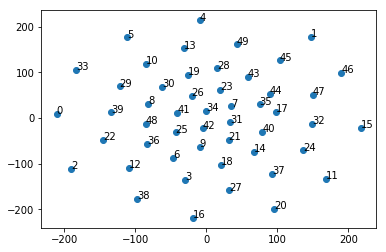

In [104]:
fig, ax = plt.subplots()
txt = np.arange(50)
ax.scatter(X_embedded[:,0],X_embedded[:,1])
for i, t in enumerate(txt):
    ax.annotate(t, (X_embedded[i,0],X_embedded[i,1]))
plt.show()

In [ ]:
#window = functools.partial(window_ops.hann_window, periodic=True)

In [ ]:
#stfts = tf.contrib.signal.stft(tf.squeeze(real_source, 2), frame_length=1024, frame_step=768,
#                                           fft_length=1024, window_fn=window)

In [133]:
x.shape

(3463074,)

In [134]:
d=librosa.stft(x, 1024, 256, 1024)
d.shape

(513, 13528)

In [148]:
d[0][0].imag

0.0

In [149]:
d[0][0].real

-0.0074171498

In [160]:
np.concatenate((np.arange(6).reshape(2,3),np.arange(6).reshape(2,3)),axis=-1).shape

(2, 6)

In [155]:
a = np.array([1,2,3]).astype(complex)
a.imag = np.array([2,4,6])
a

array([ 1.+2.j,  2.+4.j,  3.+6.j])

In [135]:
xx=librosa.core.istft(d, hop_length=256)
xx.shape

(3462912,)

In [108]:
d=librosa.core.stft(x, n_fft=1024, hop_length=256, win_length=1024)
d.shape

(513, 13528)

In [110]:
xx=librosa.core.istft(d, hop_length=256)
xx.shape

(3462912,)